In [1]:
import kagglehub

# Download latest version
path_8k = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path_8k)

Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


In [2]:
!ls /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1

captions.txt  Images


In [3]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/phase3'

import sys
sys.path.append('/content/drive/MyDrive/phase3')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import math
import torch
from torch import nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
import time
import numpy as np

# for plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from ph3 import *
import os
import torch.optim as optim
import torch
import pickle


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
if torch.cuda.is_available:
  print('Good to go!')
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  print('Please set GPU via Edit -> Notebook Settings.')

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

Good to go!


In [7]:
# Configuration
image_size = (128, 128)
flicker = '30k'
data_path = {'8k':f"{path_8k}/Images/", '30k': f'{base_dir}/flicker30k/'}
captions_path = {'8k':f"{path_8k}/captions.txt", '30k':f"{base_dir}/captions.csv"}
data_dict_path = {'8k':f"{base_dir}/image_captioning_dataset.pt", '30k':f"{base_dir}/flicker30k.pt"}

data_dict = load_data(data_dict_path, captions_path, data_path, image_size, flicker=flicker)

/content/drive/MyDrive/phase3/ph3.py:231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(file_path[flicker])


Dataset loaded successfully.


In [8]:
num_train = len(data_dict['train_images'])
num_val = len(data_dict['val_images'])
print(f'num_train: {num_train}')
print(f'num_val: {num_val}')

num_train: 9899
num_val: 100


### function for data augmentation

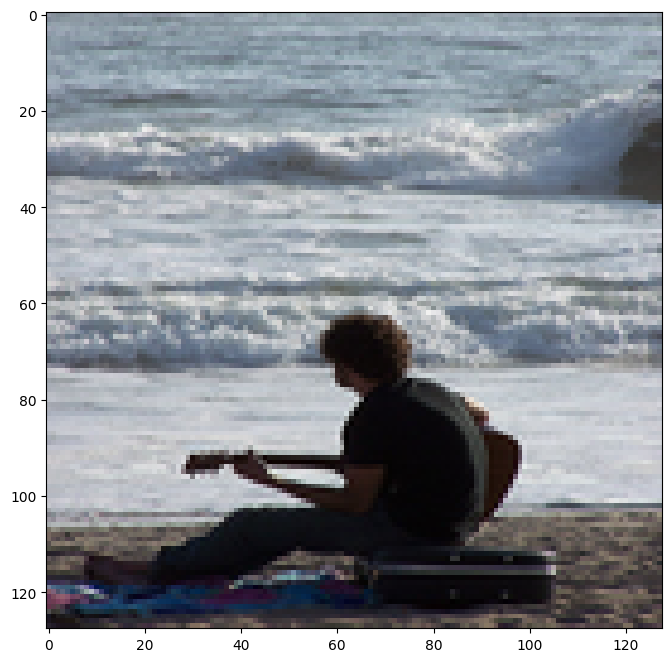

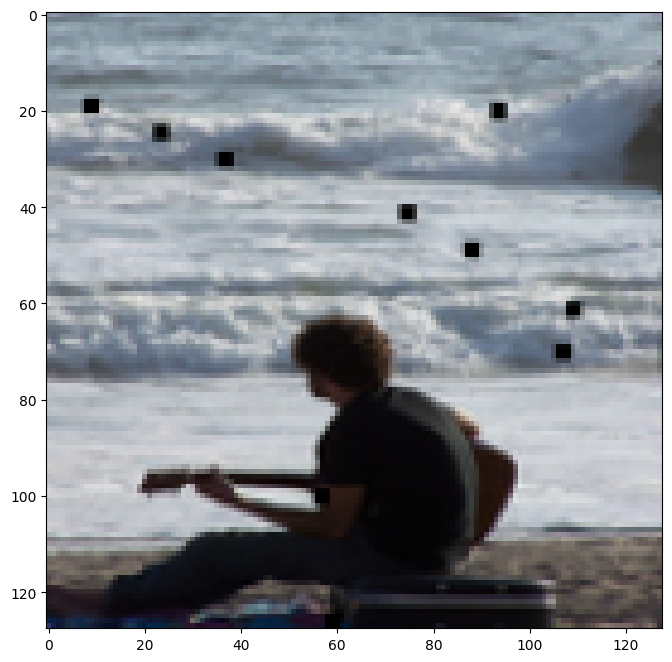

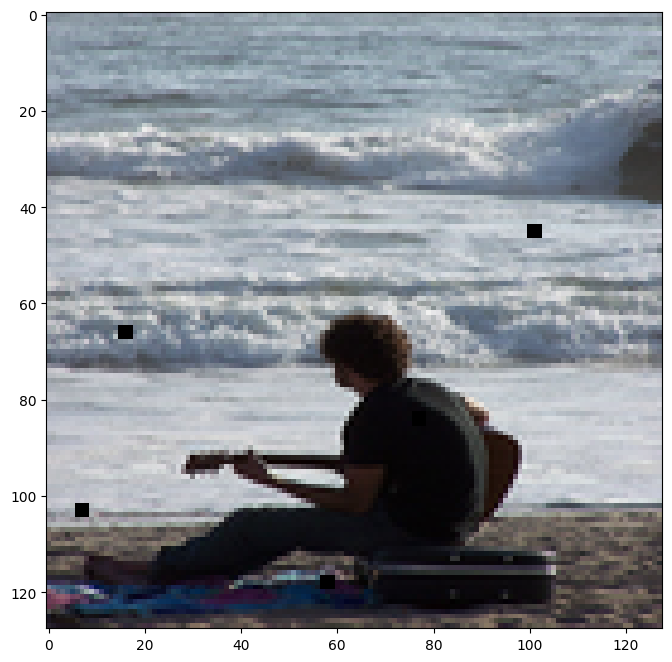

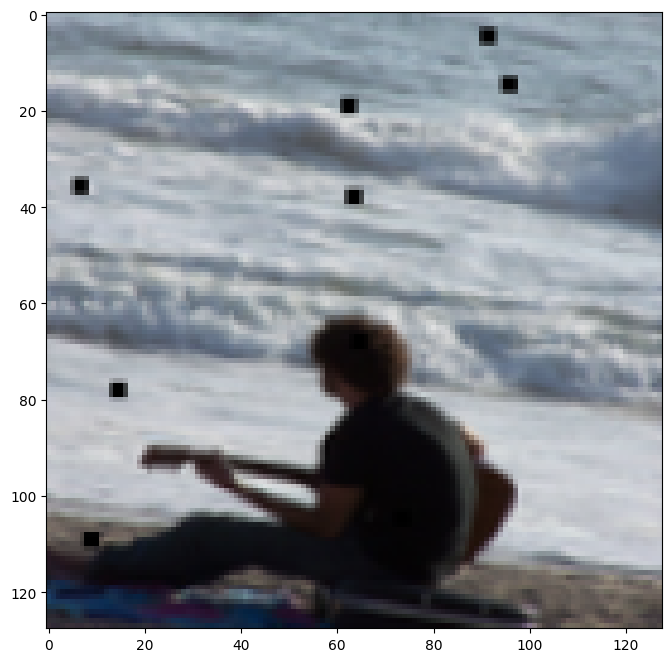

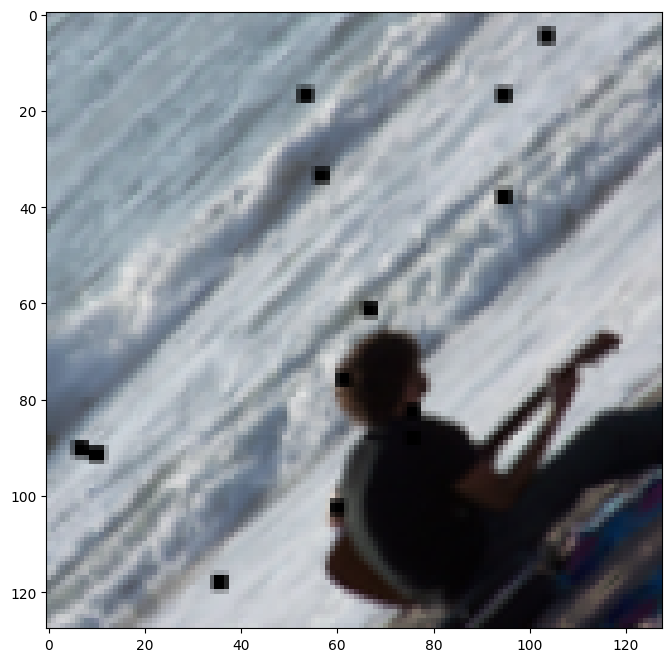

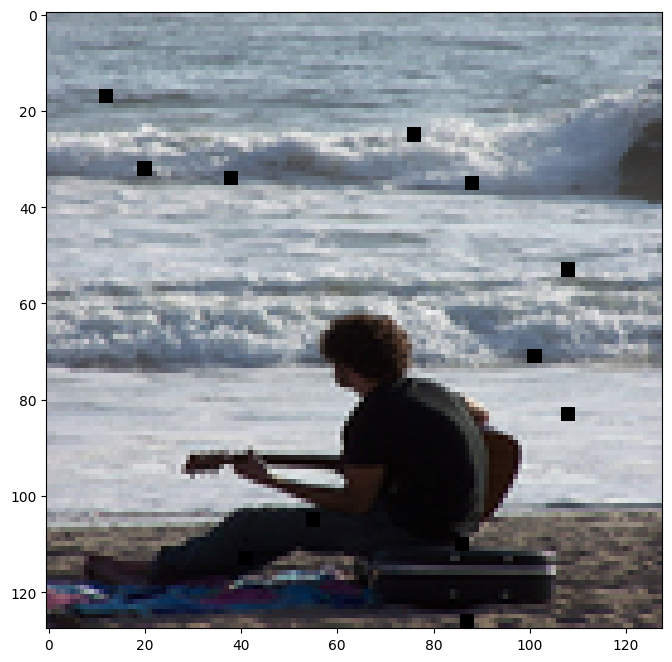

In [9]:
ag_img = process_images(data_dict['train_images'][0], image_size=image_size, augment=True)
for i in range(ag_img.shape[0]):
    img = ag_img[i].permute(1, 2, 0).to(torch.int32)
    plt.imshow(img)
    plt.show()

In [10]:
data_dict['train_captions'].shape

torch.Size([9899, 5, 38])

In [11]:
len(data_dict["vocab"]["idx_to_token"])

8833

We have 6,472 lists of captions.

- Each list contains 5 captions.  
- Each caption consists of 40 tokens (with padding).  
- Each token is represented as a vector of size 8,908 (one-hot encoding).  


In [12]:
PAD_index = 0

`start = 1`,
`end = 2`,
`pad = 0`

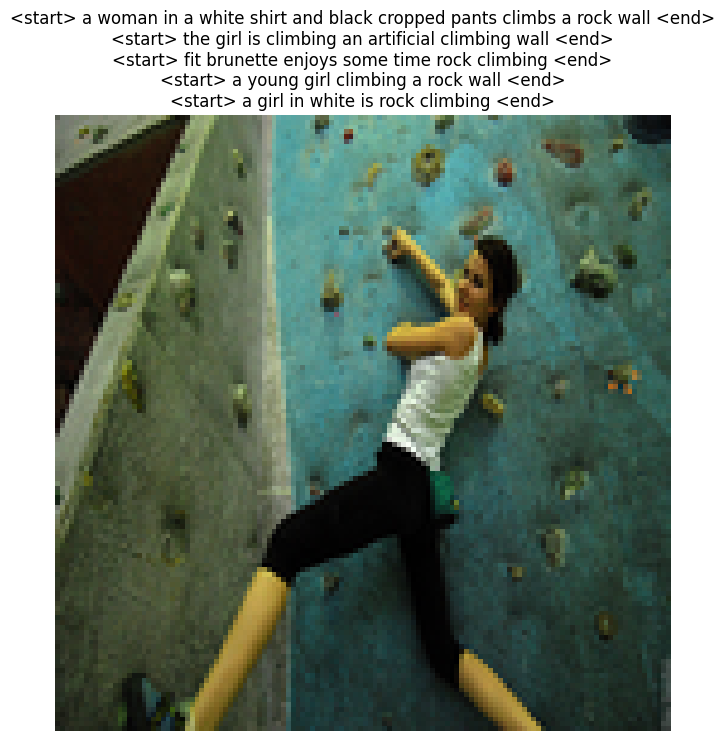

In [13]:
# Sample a minibatch and show the reshaped 112x112 images and captions
image_num = 1375

sample_images = data_dict['train_images'][image_num]
sample_captions = data_dict['train_captions'][image_num]
plt.imshow(process_images(sample_images, image_size=image_size).permute(1, 2, 0).to(torch.int32))
plt.axis('off')
caption_str = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
caption_str = "\n".join(caption_str)
plt.title(caption_str)
plt.show()

### RNN

In [14]:
# create the image captioning model
rnn_model = CaptioningRNN(
          cell_type='attention',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280,
          hidden_dim=512,
          wordvec_dim=256,
          ignore_index=PAD_index,
          **to_float_cuda)

In [ ]:
# Model and file paths
name = 'attention'
version = 7
checkpoint_path = f'{base_dir}/checkpoint/{name}_{version}_checkpoint.pth'
model_path = f'{base_dir}/models/{name}_{version}_checkpoint.pth'
history_path = f'{base_dir}/history/{name}_{version}.pth'

lr = 1e-3
epochs = 400
lr_decay = 0.97
batch_size=256
weight_decay = 5e-4
interval = 20

if os.path.exists(checkpoint_path):
    # Resume training from checkpoint
    print(f"Resuming training from checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    model = rnn_model.to(device)
    model.load_state_dict(checkpoint['model_state'])

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer.load_state_dict(checkpoint['optimizer_state'])

    # scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: lr_decay ** (epoch // interval))
    # scheduler = CosineAnnealingLR(optimizer, T_max=240)
    scheduler = None

    if checkpoint['scheduler_state'] is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state'])

    start_epoch = checkpoint['epoch']
    train_loss_history = checkpoint['train_loss_history']
    val_loss_history = checkpoint['val_loss_history']
    best_val_loss = checkpoint['best_val_loss']
    print(f"Training will resume from epoch {start_epoch}.\n")

else:
    # Start new training
    print(f"Training new model: {name}\n")

    # Initialize model and optimizer
    model = rnn_model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # optimizer = optim.SGD(model.fc.parameters(), min_lr)

    # Define scheduler
    # scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: lr_decay ** (epoch // interval))
    # scheduler = CosineAnnealingLR(optimizer, T_max=240)
    scheduler = None

    # Initialize metrics and state
    start_epoch = 0
    best_val_acc = 0.0

# Train model
train_loss_history, val_loss_history = train_captioning_model(
    rnn_model, optimizer, data_dict, device='cuda', dtype=torch.float32, lr=lr,
    epochs=epochs, batch_size=batch_size, scheduler=scheduler, val_perc=1,
    image_size=image_size, verbose=True, checkpoint_path=checkpoint_path
)

# Save final model and history after training completes
torch.save(model.state_dict(), model_path)
print(f"Final model saved at: {model_path}")

with open(history_path, 'wb') as f:
    pickle.dump((train_loss_history, val_loss_history), f)
print(f"Training history saved at: {history_path}")

Resuming training from checkpoint: /content/drive/MyDrive/phase3/checkpoint/attention_7_checkpoint.pth
Training will resume from epoch 381.

Resuming training from checkpoint...


<ipython-input-15-0187b70e912e>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
/content/drive/MyDrive/phase3/ph3.py:1089: FutureW

Resumed training from epoch 381
Epoch 382/400
  Batch 1/38, lr = 0.001, Loss = 44.2202
  Batch 11/38, lr = 0.001, Loss = 32.0314
  Batch 21/38, lr = 0.001, Loss = 44.3356
  Batch 31/38, lr = 0.001, Loss = 40.6487
  Training Loss: 35.9813
  Validation Loss: 40.8652
Epoch 383/400
  Batch 1/38, lr = 0.001, Loss = 25.3404


In [ ]:
plt.plot(train_loss_history)

In [ ]:
plt.plot(val_loss_history)

In [ ]:
batch_size = 5
from torchvision.utils import make_grid
from torchvision import transforms

for split in ['train', 'val']:
  sample_idx = torch.randint(0, num_train if split=='train' else num_val, (batch_size,))
  sample_images = process_images_batch([data_dict[split+'_images'][i] for i in sample_idx]
                            , image_size=image_size, augment=False)
  sample_captions = data_dict[split+'_captions'][sample_idx][:,random.randint(0, 4),:]

  # decode_captions is loaded from a4_helper.py
  gt_captions = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
  model.eval()
  generated_captions, attn_weights_all = model.sample(sample_images)
  generated_captions = decode_captions(generated_captions, data_dict['vocab']['idx_to_token'])

  for i in range(batch_size):
    plt.imshow(sample_images[i].permute(1, 2, 0)/255)
    plt.axis('off')
    plt.title('%s\nAttention LSTM Generated:%s\nGT:%s' % (split, generated_captions[i], gt_captions[i]))
    plt.show()

    tokens = generated_captions[i].split(' ')

    vis_attn = []
    for j in range(len(tokens)):
      img = sample_images[i]
      attn_weights = attn_weights_all[i][j]
      token = tokens[j]
      img_copy = attention_visualizer(img, attn_weights, token)
      vis_attn.append(transforms.ToTensor()(img_copy))

    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    vis_attn = make_grid(vis_attn, nrow=8)
    plt.imshow(torch.flip(vis_attn, dims=(0,)).permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    plt.rcParams['figure.figsize'] = (10.0, 8.0)